#### Graph Neural Network Project CSE 881

In [35]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import GCNConv, GATConv, AGNNConv
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
from skopt import Optimizer
from skopt.utils import use_named_args
from skopt.space import Real, Integer
np.int = int

# Setting Random Seed
random_seed = 42

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

# Load data
adj = sp.load_npz("adj.npz") 
feat = np.load("features.npy") 
labels = np.load("labels.npy") 

splits = json.load(open('splits.json'))
idx_train0, idx_test = splits['idx_train'], splits['idx_test']

# train data into train and validation 
idx_train, idx_val = train_test_split(idx_train0, test_size=0.2, random_state=42)

# masking data
edge_index, _ = from_scipy_sparse_matrix(adj)
x = torch.tensor(feat, dtype=torch.float)
y = torch.full((x.size(0),), -1, dtype=torch.long)
y[idx_train0] = torch.tensor(labels, dtype=torch.long)
train_mask = torch.zeros(x.size(0), dtype=torch.bool)
train_mask[idx_train] = True
val_mask = torch.zeros(x.size(0), dtype=torch.bool)
val_mask[idx_val] = True
test_mask = torch.zeros(x.size(0), dtype=torch.bool)
test_mask[idx_test] = True

class_counts = torch.bincount(y[idx_train0].type(torch.long))
class_weights = 1.0 / torch.Tensor(class_counts.float())

# graph data object
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data0 = data.clone()

In [2]:
# GCN Network
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_hidden, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, num_hidden)
        self.conv2 = GCNConv(num_hidden, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [3]:
# GAT Network
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_hidden, num_classes, num_heads=4):
        super().__init__()
        self.conv1 = GATConv(num_node_features, num_hidden, heads=num_heads)
        self.conv2 = GATConv(num_hidden * num_heads, num_classes, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


In [4]:
# AGNN Network
class AGNN(torch.nn.Module):
    def __init__(self, num_node_features, num_hidden, num_classes):
        super().__init__()
        self.lin1 = torch.nn.Linear(num_node_features, num_hidden)
        self.conv1 = AGNNConv(requires_grad=True)
        self.conv2 = AGNNConv(requires_grad=True)
        self.lin2 = torch.nn.Linear(num_hidden, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.lin1(x)
        x = F.relu(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin2(x)

        return F.log_softmax(x, dim=1)


In [36]:
# Loading data to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

In [6]:
## Plotting and evaluation definitions
def plot_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.show()


def evaluate_and_report(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = out.argmax(dim=1)

    y_true = data.y[data.val_mask].cpu().numpy()
    y_pred = y_pred[data.val_mask].cpu().numpy()

    return y_true, y_pred


def plot_confusion_matrix(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
    plt.title("Confusion Matrix")
    plt.show()


def evaluate_and_get_probabilities(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        probabilities = F.softmax(out, dim=1)

    y_true = data.y[data.val_mask].cpu().numpy()
    probabilities = probabilities[data.val_mask].cpu().numpy()

    return y_true, probabilities


def plot_multiclass_roc_curve(y_true, y_score, n_classes):
    y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_multiclass_precision_recall_curve(y_true, y_score, n_classes):
    y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))

    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_true_binarized[:, i], y_score[:, i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label=f'Class {i} (AP={average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()


In [7]:
# Train and evaluation function
def train_and_evaluate(data, model, optimizer, patience=5):
    best_val_loss = float('inf')
    counter = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask], weight=class_weights)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask],weight=class_weights)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            
        else:
            counter += 1

        if counter >= patience:
            break

        pred = model(data).argmax(dim=1)
        correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
        acc = int(correct) / int(data.val_mask.sum())

        correct_train = (pred[data.train_mask] == data.y[data.train_mask]).sum()
        acc_train = int(correct_train) / int(data.train_mask.sum())
        
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(acc_train)
        val_accuracies.append(acc)
    return acc, train_losses, val_losses, train_accuracies, val_accuracies



In [8]:
# Training final model
def train_final_model(data, model, optimizer, patience=3, num_epochs=200):
    best_val_loss = float('inf')
    counter = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask],weight=class_weights)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask],weight=class_weights)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            best_model_state = model.state_dict()
            
            
        else:
            counter += 1

        if counter >= patience:
            break

        pred = model(data).argmax(dim=1)
        correct_train = (pred[data.train_mask] == data.y[data.train_mask]).sum()
        acc_train = int(correct_train) / int(data.train_mask.sum())
        correct_val = (pred[data.val_mask] == data.y[data.val_mask]).sum()
        acc_val = int(correct_val) / int(data.val_mask.sum())

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(acc_train)
        val_accuracies.append(acc_val)
    
    return best_model_state, train_losses, val_losses, train_accuracies, val_accuracies



#### GCN Parameters tuning

In [9]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'weight_decay': [1e-4, 5e-4, 1e-3],
    'num_hidden': [32, 64, 128]
}

best_params = None
best_acc = 0
idx_train0 = np.array(idx_train0)
for lr in param_grid['lr']:
    for weight_decay in param_grid['weight_decay']:
        for num_hidden in param_grid['num_hidden']:
            avg_acc = 0
            for train_idx, val_idx in kf.split(idx_train0):
                idx_train, idx_val = idx_train0[train_idx], idx_train0[val_idx]
                train_mask = torch.zeros(x.size(0), dtype=torch.bool)
                train_mask[idx_train] = True
                val_mask = torch.zeros(x.size(0), dtype=torch.bool)
                val_mask[idx_val] = True

                data.train_mask = train_mask
                data.val_mask = val_mask
                
                model = GCN(num_node_features=data.x.shape[1], num_hidden=num_hidden, num_classes=data.y.max().item() + 1).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                acc, train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(data, model, optimizer)
                avg_acc += acc

            avg_acc /= n_splits
            print(f"lr: {lr}, weight_decay: {weight_decay}, num_hidden: {num_hidden}, Avg. Accuracy: {avg_acc:.4f}")
            
            if avg_acc > best_acc:
                best_acc = avg_acc
                best_params = {'lr': lr, 'weight_decay': weight_decay, 'num_hidden': num_hidden}

print(f"Best parameters: {best_params}, Best average accuracy: {best_acc:.4f}")


lr: 0.001, weight_decay: 0.0001, num_hidden: 32, Avg. Accuracy: 0.8528
lr: 0.001, weight_decay: 0.0001, num_hidden: 64, Avg. Accuracy: 0.8488
lr: 0.001, weight_decay: 0.0001, num_hidden: 128, Avg. Accuracy: 0.8387
lr: 0.001, weight_decay: 0.0005, num_hidden: 32, Avg. Accuracy: 0.8568
lr: 0.001, weight_decay: 0.0005, num_hidden: 64, Avg. Accuracy: 0.8488
lr: 0.001, weight_decay: 0.0005, num_hidden: 128, Avg. Accuracy: 0.8508
lr: 0.001, weight_decay: 0.001, num_hidden: 32, Avg. Accuracy: 0.8387
lr: 0.001, weight_decay: 0.001, num_hidden: 64, Avg. Accuracy: 0.8468
lr: 0.001, weight_decay: 0.001, num_hidden: 128, Avg. Accuracy: 0.8528
lr: 0.01, weight_decay: 0.0001, num_hidden: 32, Avg. Accuracy: 0.8427
lr: 0.01, weight_decay: 0.0001, num_hidden: 64, Avg. Accuracy: 0.8387
lr: 0.01, weight_decay: 0.0001, num_hidden: 128, Avg. Accuracy: 0.8387
lr: 0.01, weight_decay: 0.0005, num_hidden: 32, Avg. Accuracy: 0.8367
lr: 0.01, weight_decay: 0.0005, num_hidden: 64, Avg. Accuracy: 0.8467
lr: 0.01, 

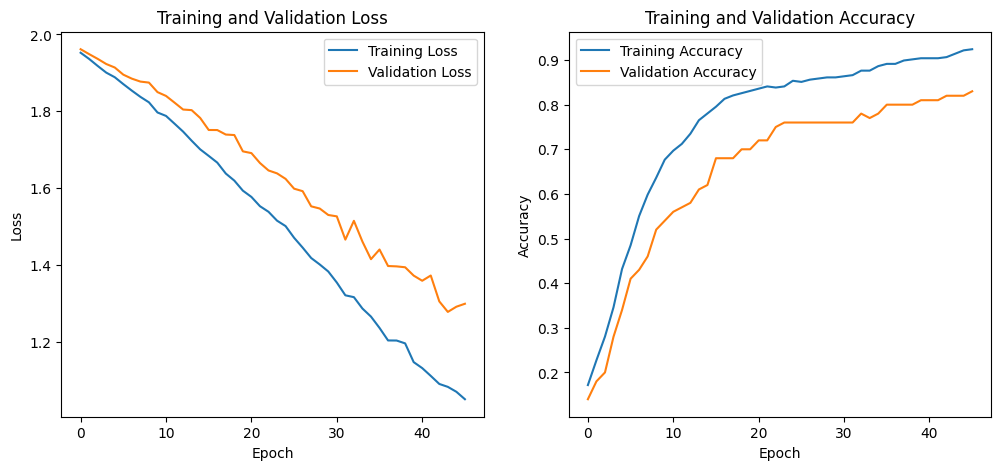

<All keys matched successfully>

In [10]:
# Visualizing results with best parameters
model_grid = GCN(num_node_features=data.x.shape[1], num_hidden=best_params['num_hidden'], num_classes=data.y.max().item() + 1).to(device)
optimizer = torch.optim.Adam(model_grid.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
best_model_state, train_loss, val_loss, train_acc, val_acc = train_final_model(data0, model_grid, optimizer)
plot_curves(train_loss, val_loss, train_acc, val_acc)

model_grid.load_state_dict(best_model_state)


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       1.00      1.00      1.00        11
           2       0.93      0.76      0.84        34
           3       0.69      0.92      0.79        12
           4       0.82      0.90      0.86        10
           5       0.83      0.62      0.71         8
           6       0.78      0.93      0.85        15

    accuracy                           0.84       100
   macro avg       0.84      0.85      0.83       100
weighted avg       0.85      0.84      0.84       100



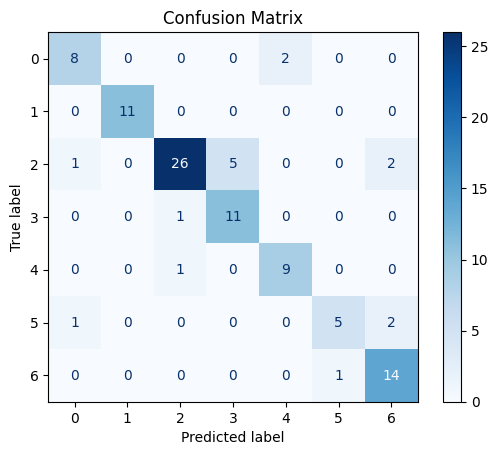

In [11]:
y_true, y_pred = evaluate_and_report(model_grid, data0)
print("Classification Report:\n", classification_report(y_true, y_pred))

class_labels = np.unique(labels)
plot_confusion_matrix(y_true, y_pred, labels=class_labels)


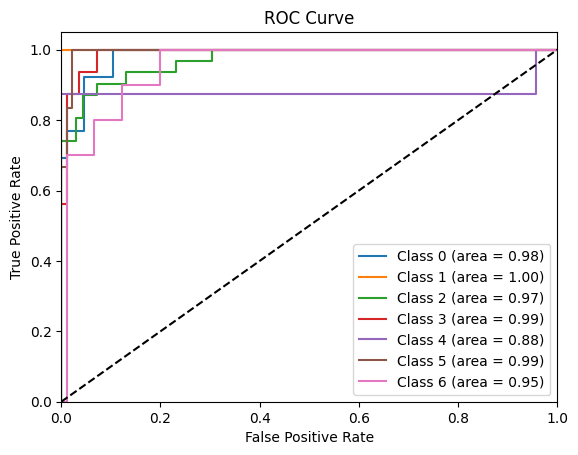

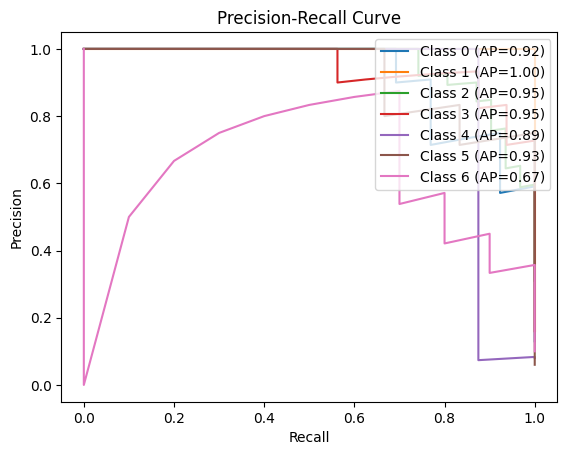

In [71]:
y_true, probabilities = evaluate_and_get_probabilities(model_grid, data0)

n_classes = 7
plot_multiclass_roc_curve(y_true, probabilities, n_classes=n_classes)
plot_multiclass_precision_recall_curve(y_true, probabilities, n_classes=n_classes)

## GAT Tuning

In [13]:

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'weight_decay': [1e-4, 5e-4, 1e-3],
    'num_hidden': [32, 64, 128]
}

best_params = None
best_acc = 0
idx_train0 = np.array(idx_train0)
for lr in param_grid['lr']:
    for weight_decay in param_grid['weight_decay']:
        for num_hidden in param_grid['num_hidden']:
            avg_acc = 0
            for train_idx, val_idx in kf.split(idx_train0):
                idx_train, idx_val = idx_train0[train_idx], idx_train0[val_idx]
                train_mask = torch.zeros(x.size(0), dtype=torch.bool)
                train_mask[idx_train] = True
                val_mask = torch.zeros(x.size(0), dtype=torch.bool)
                val_mask[idx_val] = True

                data.train_mask = train_mask
                data.val_mask = val_mask
                
                model = GAT(num_node_features=data.x.shape[1], num_hidden=num_hidden, num_classes=data.y.max().item() + 1).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                acc, train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(data, model, optimizer)
                avg_acc += acc

            avg_acc /= n_splits
            print(f"lr: {lr}, weight_decay: {weight_decay}, num_hidden: {num_hidden}, Avg. Accuracy: {avg_acc:.4f}")
            
            if avg_acc > best_acc:
                best_acc = avg_acc
                best_params = {'lr': lr, 'weight_decay': weight_decay, 'num_hidden': num_hidden}

print(f"Best parameters: {best_params}, Best average accuracy: {best_acc:.4f}")


lr: 0.001, weight_decay: 0.0001, num_hidden: 32, Avg. Accuracy: 0.8407
lr: 0.001, weight_decay: 0.0001, num_hidden: 64, Avg. Accuracy: 0.8225
lr: 0.001, weight_decay: 0.0001, num_hidden: 128, Avg. Accuracy: 0.8246
lr: 0.001, weight_decay: 0.0005, num_hidden: 32, Avg. Accuracy: 0.8266
lr: 0.001, weight_decay: 0.0005, num_hidden: 64, Avg. Accuracy: 0.8347
lr: 0.001, weight_decay: 0.0005, num_hidden: 128, Avg. Accuracy: 0.8205
lr: 0.001, weight_decay: 0.001, num_hidden: 32, Avg. Accuracy: 0.8346
lr: 0.001, weight_decay: 0.001, num_hidden: 64, Avg. Accuracy: 0.8286
lr: 0.001, weight_decay: 0.001, num_hidden: 128, Avg. Accuracy: 0.8407
lr: 0.01, weight_decay: 0.0001, num_hidden: 32, Avg. Accuracy: 0.8427
lr: 0.01, weight_decay: 0.0001, num_hidden: 64, Avg. Accuracy: 0.8346
lr: 0.01, weight_decay: 0.0001, num_hidden: 128, Avg. Accuracy: 0.7983
lr: 0.01, weight_decay: 0.0005, num_hidden: 32, Avg. Accuracy: 0.8286
lr: 0.01, weight_decay: 0.0005, num_hidden: 64, Avg. Accuracy: 0.8225
lr: 0.01, 

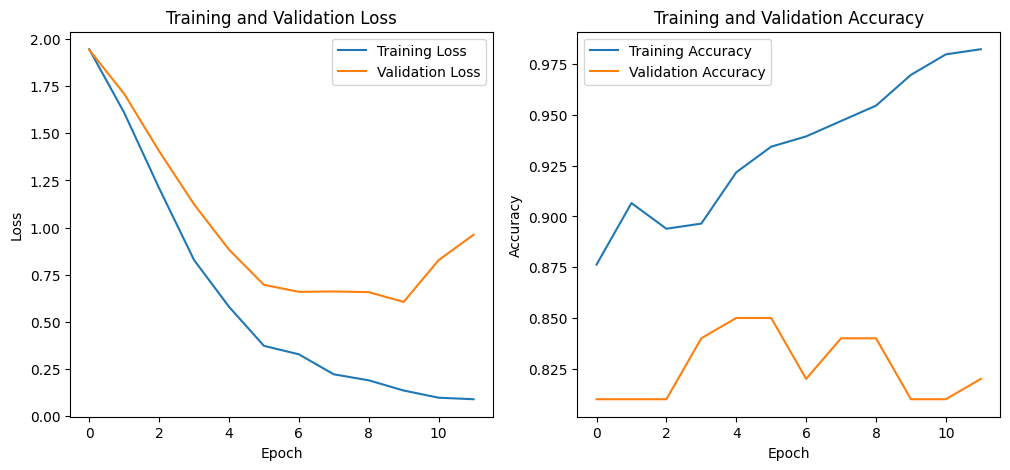

<All keys matched successfully>

In [14]:
# Visualizing results with best parameters
model_grid = GAT(num_node_features=data.x.shape[1], num_hidden=best_params['num_hidden'], num_classes=data.y.max().item() + 1).to(device)
optimizer = torch.optim.Adam(model_grid.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
best_model_state, train_loss, val_loss, train_acc, val_acc = train_final_model(data0, model_grid, optimizer)
plot_curves(train_loss, val_loss, train_acc, val_acc)

model_grid.load_state_dict(best_model_state)


Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       1.00      1.00      1.00        11
           2       0.81      0.88      0.85        34
           3       0.85      0.92      0.88        12
           4       1.00      0.70      0.82        10
           5       1.00      0.50      0.67         8
           6       0.67      0.67      0.67        15

    accuracy                           0.81       100
   macro avg       0.85      0.78      0.80       100
weighted avg       0.83      0.81      0.81       100



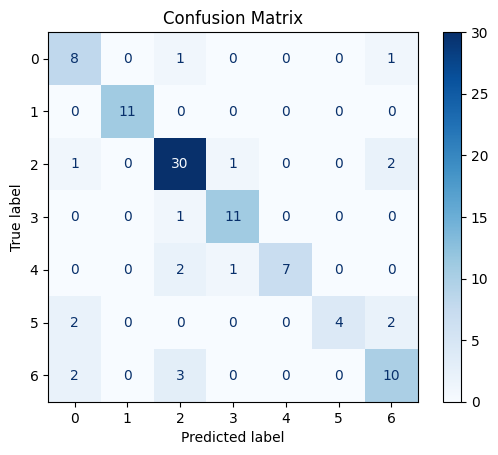

In [15]:
y_true, y_pred = evaluate_and_report(model_grid, data0)
print("Classification Report:\n", classification_report(y_true, y_pred))

class_labels = np.unique(labels)
plot_confusion_matrix(y_true, y_pred, labels=class_labels)


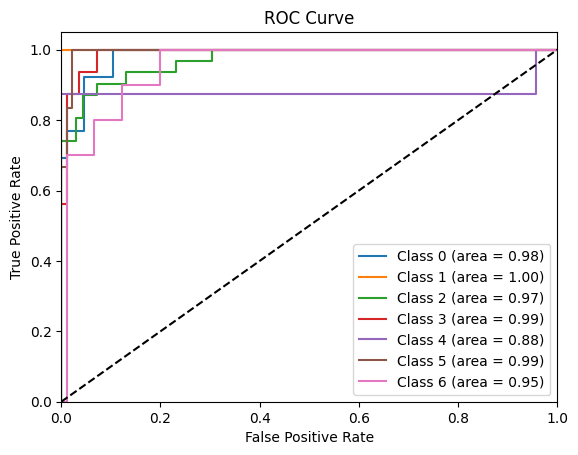

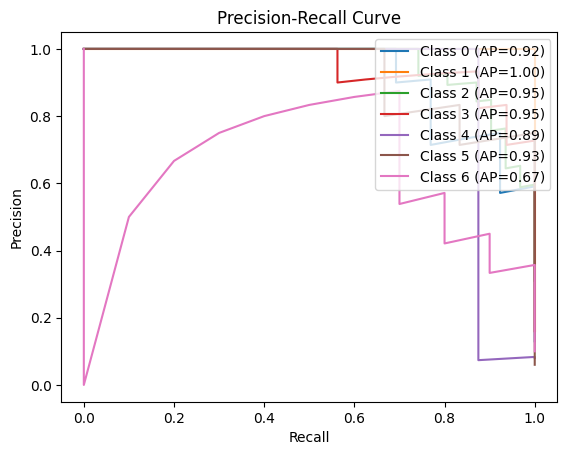

In [68]:
y_true, probabilities = evaluate_and_get_probabilities(model_grid, data0)

n_classes = 7
plot_multiclass_roc_curve(y_true, probabilities, n_classes=n_classes)
plot_multiclass_precision_recall_curve(y_true, probabilities, n_classes=n_classes)

## AGNN Tuning 

In [17]:

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'weight_decay': [1e-4, 5e-4, 1e-3],
    'num_hidden': [32, 64, 128]
}

best_params = None
best_acc = 0
idx_train0 = np.array(idx_train0)
for lr in param_grid['lr']:
    for weight_decay in param_grid['weight_decay']:
        for num_hidden in param_grid['num_hidden']:
            avg_acc = 0
            for train_idx, val_idx in kf.split(idx_train0):
                idx_train, idx_val = idx_train0[train_idx], idx_train0[val_idx]
                train_mask = torch.zeros(x.size(0), dtype=torch.bool)
                train_mask[idx_train] = True
                val_mask = torch.zeros(x.size(0), dtype=torch.bool)
                val_mask[idx_val] = True

                data.train_mask = train_mask
                data.val_mask = val_mask
                
                model = AGNN(num_node_features=data.x.shape[1], num_hidden=num_hidden, num_classes=data.y.max().item() + 1).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                acc, train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(data, model, optimizer)
                avg_acc += acc

            avg_acc /= n_splits
            print(f"lr: {lr}, weight_decay: {weight_decay}, num_hidden: {num_hidden}, Avg. Accuracy: {avg_acc:.4f}")
            
            if avg_acc > best_acc:
                best_acc = avg_acc
                best_params = {'lr': lr, 'weight_decay': weight_decay, 'num_hidden': num_hidden}

print(f"Best parameters: {best_params}, Best average accuracy: {best_acc:.4f}")


lr: 0.001, weight_decay: 0.0001, num_hidden: 32, Avg. Accuracy: 0.8508
lr: 0.001, weight_decay: 0.0001, num_hidden: 64, Avg. Accuracy: 0.8468
lr: 0.001, weight_decay: 0.0001, num_hidden: 128, Avg. Accuracy: 0.8488
lr: 0.001, weight_decay: 0.0005, num_hidden: 32, Avg. Accuracy: 0.8508
lr: 0.001, weight_decay: 0.0005, num_hidden: 64, Avg. Accuracy: 0.8548
lr: 0.001, weight_decay: 0.0005, num_hidden: 128, Avg. Accuracy: 0.8447
lr: 0.001, weight_decay: 0.001, num_hidden: 32, Avg. Accuracy: 0.8488
lr: 0.001, weight_decay: 0.001, num_hidden: 64, Avg. Accuracy: 0.8447
lr: 0.001, weight_decay: 0.001, num_hidden: 128, Avg. Accuracy: 0.8488
lr: 0.01, weight_decay: 0.0001, num_hidden: 32, Avg. Accuracy: 0.8488
lr: 0.01, weight_decay: 0.0001, num_hidden: 64, Avg. Accuracy: 0.8468
lr: 0.01, weight_decay: 0.0001, num_hidden: 128, Avg. Accuracy: 0.8428
lr: 0.01, weight_decay: 0.0005, num_hidden: 32, Avg. Accuracy: 0.8387
lr: 0.01, weight_decay: 0.0005, num_hidden: 64, Avg. Accuracy: 0.8407
lr: 0.01, 

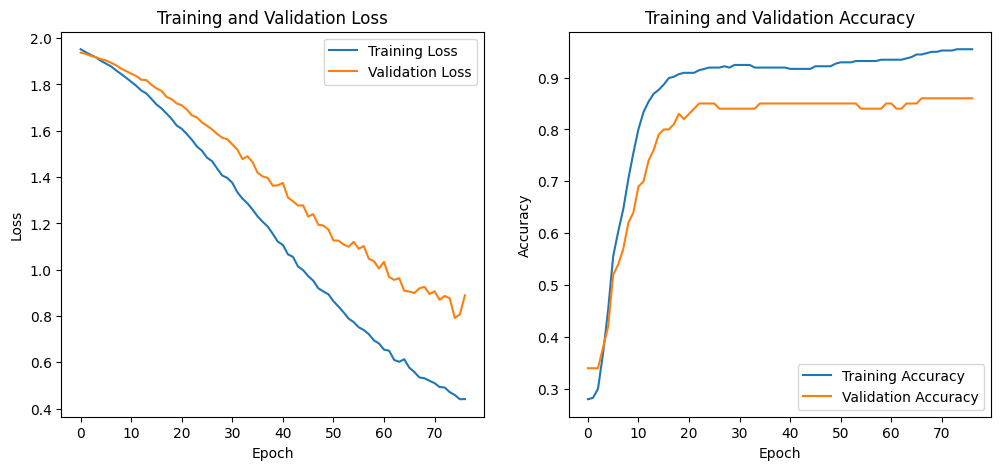

<All keys matched successfully>

In [18]:
# Visualizing results with best parameters
model_grid = AGNN(num_node_features=data.x.shape[1], num_hidden=best_params['num_hidden'], num_classes=data.y.max().item() + 1).to(device)
optimizer = torch.optim.Adam(model_grid.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
best_model_state, train_loss, val_loss, train_acc, val_acc = train_final_model(data0, model_grid, optimizer)
plot_curves(train_loss, val_loss, train_acc, val_acc)

model_grid.load_state_dict(best_model_state)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       1.00      1.00      1.00        11
           2       0.91      0.91      0.91        34
           3       0.92      0.92      0.92        12
           4       0.75      0.90      0.82        10
           5       0.62      0.62      0.62         8
           6       0.80      0.80      0.80        15

    accuracy                           0.86       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.86      0.86      0.86       100



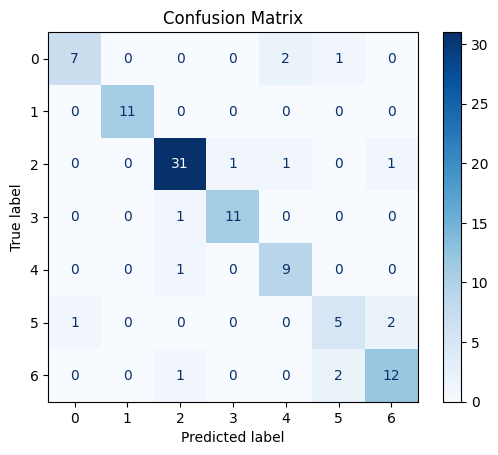

In [19]:
y_true, y_pred = evaluate_and_report(model_grid, data0)
print("Classification Report:\n", classification_report(y_true, y_pred))

class_labels = np.unique(labels)
plot_confusion_matrix(y_true, y_pred, labels=class_labels)

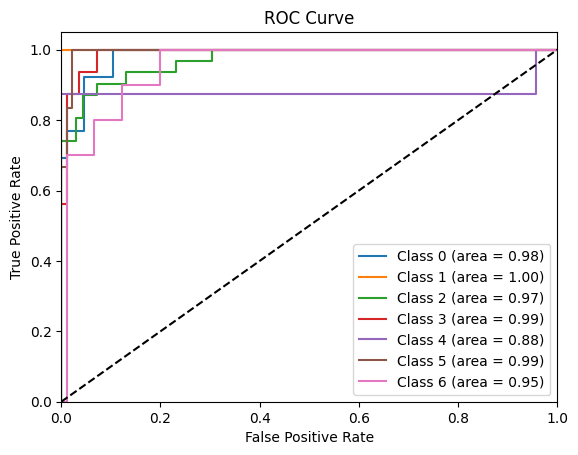

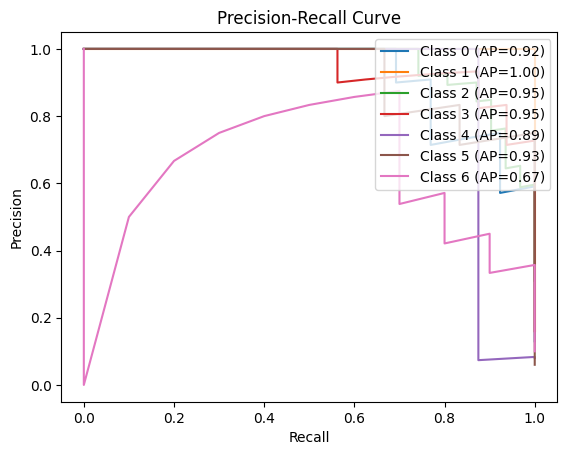

In [69]:
y_true, probabilities = evaluate_and_get_probabilities(model_grid, data0)

n_classes = 7
plot_multiclass_roc_curve(y_true, probabilities, n_classes=n_classes)
plot_multiclass_precision_recall_curve(y_true, probabilities, n_classes=n_classes)

## tuning with smaller grid search parameters

In [38]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
param_grid = {
    'lr': [0.01, 0.03, 0.05],
    'weight_decay': [1e-4 ,1e-3],
    'num_hidden': [16 ,32, 64]
}

best_params = None
best_acc = 0
idx_train0 = np.array(idx_train0)
for lr in param_grid['lr']:
    for weight_decay in param_grid['weight_decay']:
        for num_hidden in param_grid['num_hidden']:
            avg_acc = 0
            for train_idx, val_idx in kf.split(idx_train0):
                idx_train, idx_val = idx_train0[train_idx], idx_train0[val_idx]
                train_mask = torch.zeros(x.size(0), dtype=torch.bool)
                train_mask[idx_train] = True
                val_mask = torch.zeros(x.size(0), dtype=torch.bool)
                val_mask[idx_val] = True

                data.train_mask = train_mask
                data.val_mask = val_mask
                
                model = GCN(num_node_features=data.x.shape[1], num_hidden=num_hidden, num_classes=data.y.max().item() + 1).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                acc, train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(data, model, optimizer)
                avg_acc += acc

            avg_acc /= n_splits
            print(f"lr: {lr}, weight_decay: {weight_decay}, num_hidden: {num_hidden}, Avg. Accuracy: {avg_acc:.4f}")

            if avg_acc > best_acc:
                best_acc = avg_acc
                best_params = {'lr': lr, 'weight_decay': weight_decay, 'num_hidden': num_hidden}

print(f"Best parameters: {best_params}, Best average accuracy: {best_acc:.4f}")



lr: 0.01, weight_decay: 0.0001, num_hidden: 16, Avg. Accuracy: 0.8407
lr: 0.01, weight_decay: 0.0001, num_hidden: 32, Avg. Accuracy: 0.8346
lr: 0.01, weight_decay: 0.0001, num_hidden: 64, Avg. Accuracy: 0.8427
lr: 0.01, weight_decay: 0.001, num_hidden: 16, Avg. Accuracy: 0.8468
lr: 0.01, weight_decay: 0.001, num_hidden: 32, Avg. Accuracy: 0.8347
lr: 0.01, weight_decay: 0.001, num_hidden: 64, Avg. Accuracy: 0.8468
lr: 0.03, weight_decay: 0.0001, num_hidden: 16, Avg. Accuracy: 0.8447
lr: 0.03, weight_decay: 0.0001, num_hidden: 32, Avg. Accuracy: 0.8286
lr: 0.03, weight_decay: 0.0001, num_hidden: 64, Avg. Accuracy: 0.8367
lr: 0.03, weight_decay: 0.001, num_hidden: 16, Avg. Accuracy: 0.8447
lr: 0.03, weight_decay: 0.001, num_hidden: 32, Avg. Accuracy: 0.8548
lr: 0.03, weight_decay: 0.001, num_hidden: 64, Avg. Accuracy: 0.8407
lr: 0.05, weight_decay: 0.0001, num_hidden: 16, Avg. Accuracy: 0.8246
lr: 0.05, weight_decay: 0.0001, num_hidden: 32, Avg. Accuracy: 0.8468
lr: 0.05, weight_decay: 0.

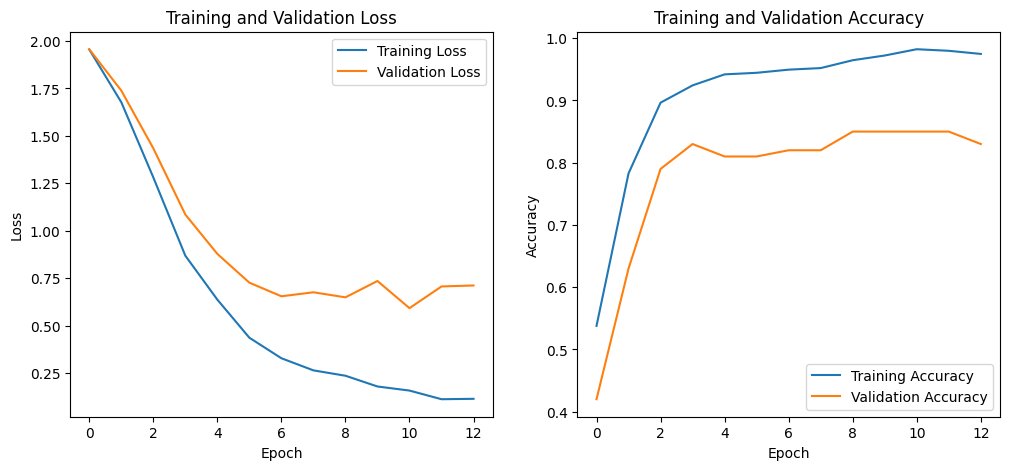

<All keys matched successfully>

In [39]:
model_grid = GCN(num_node_features=data.x.shape[1], num_hidden=best_params['num_hidden'], num_classes=data.y.max().item() + 1).to(device)
optimizer = torch.optim.Adam(model_grid.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
best_model_state, train_loss, val_loss, train_acc, val_acc = train_final_model(data0, model_grid, optimizer)
plot_curves(train_loss, val_loss, train_acc, val_acc)

model_grid.load_state_dict(best_model_state)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.69      0.82        13
           1       1.00      0.94      0.97        16
           2       0.89      0.81      0.85        31
           3       0.82      0.88      0.85        16
           4       1.00      0.75      0.86         8
           5       0.75      1.00      0.86         6
           6       0.47      0.80      0.59        10

    accuracy                           0.83       100
   macro avg       0.85      0.84      0.83       100
weighted avg       0.87      0.83      0.84       100



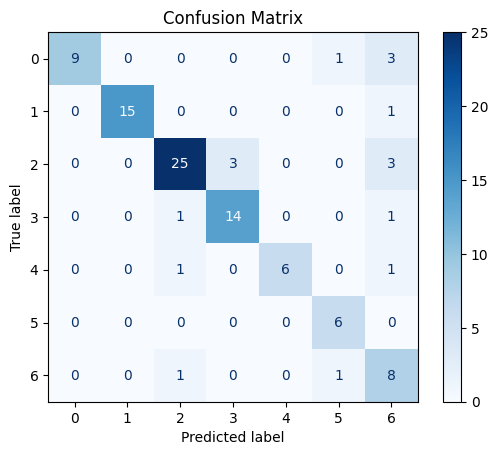

In [40]:
y_true, y_pred = evaluate_and_report(model_grid, data0)
print("Classification Report:\n", classification_report(y_true, y_pred))

class_labels = np.unique(labels)
plot_confusion_matrix(y_true, y_pred, labels=class_labels)


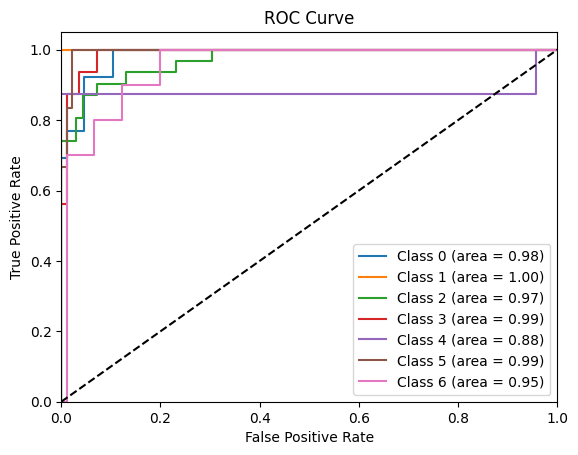

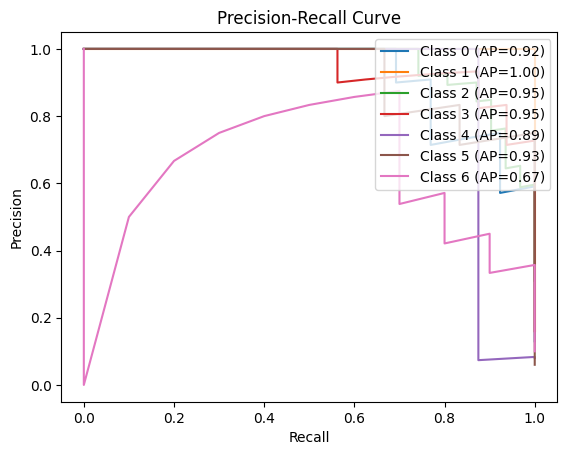

In [70]:
y_true, probabilities = evaluate_and_get_probabilities(model_grid, data0)

n_classes = 7
plot_multiclass_roc_curve(y_true, probabilities, n_classes=n_classes)
plot_multiclass_precision_recall_curve(y_true, probabilities, n_classes=n_classes)

## Random search

In [43]:

num_random_search = 20

param_grid = {
    'lr': [0.01, 0.03, 0.05],
    'weight_decay': [1e-4 ,1e-3, 1e-2],
    'num_hidden': [16 ,32, 64, 128]
}

for i in range(num_random_search):
    lr = np.random.choice(param_grid['lr'])
    weight_decay = np.random.choice(param_grid['weight_decay'])
    num_hidden = np.random.choice(param_grid['num_hidden'])

    avg_acc = 0
    for train_idx, val_idx in kf.split(idx_train0):
        idx_train, idx_val = idx_train0[train_idx], idx_train0[val_idx]
        train_mask = torch.zeros(x.size(0), dtype=torch.bool)
        train_mask[idx_train] = True
        val_mask = torch.zeros(x.size(0), dtype=torch.bool)
        val_mask[idx_val] = True

        data.train_mask = train_mask
        data.val_mask = val_mask

        model = GCN(num_node_features=data.x.shape[1], num_hidden=num_hidden, num_classes=data.y.max().item() + 1).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        acc, train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(data, model, optimizer)
        avg_acc += acc

    avg_acc /= n_splits
    print(f"Random Search Iteration {i + 1}, lr: {lr}, weight_decay: {weight_decay}, num_hidden: {num_hidden}, Avg. Accuracy: {avg_acc:.4f}")

    if avg_acc > best_acc:
        best_acc = avg_acc
        best_params = {'lr': lr, 'weight_decay': weight_decay, 'num_hidden': num_hidden}

print(f"Best parameters: {best_params}, Best average accuracy: {best_acc:.4f}")


Random Search Iteration 1, lr: 0.01, weight_decay: 0.001, num_hidden: 128, Avg. Accuracy: 0.8528
Random Search Iteration 2, lr: 0.03, weight_decay: 0.001, num_hidden: 32, Avg. Accuracy: 0.8467
Random Search Iteration 3, lr: 0.03, weight_decay: 0.001, num_hidden: 128, Avg. Accuracy: 0.8427
Random Search Iteration 4, lr: 0.03, weight_decay: 0.0001, num_hidden: 64, Avg. Accuracy: 0.8387
Random Search Iteration 5, lr: 0.03, weight_decay: 0.001, num_hidden: 128, Avg. Accuracy: 0.8468
Random Search Iteration 6, lr: 0.03, weight_decay: 0.001, num_hidden: 32, Avg. Accuracy: 0.8387
Random Search Iteration 7, lr: 0.03, weight_decay: 0.01, num_hidden: 128, Avg. Accuracy: 0.8447
Random Search Iteration 8, lr: 0.05, weight_decay: 0.001, num_hidden: 64, Avg. Accuracy: 0.8448
Random Search Iteration 9, lr: 0.01, weight_decay: 0.001, num_hidden: 128, Avg. Accuracy: 0.8468
Random Search Iteration 10, lr: 0.01, weight_decay: 0.0001, num_hidden: 32, Avg. Accuracy: 0.8427
Random Search Iteration 11, lr: 0

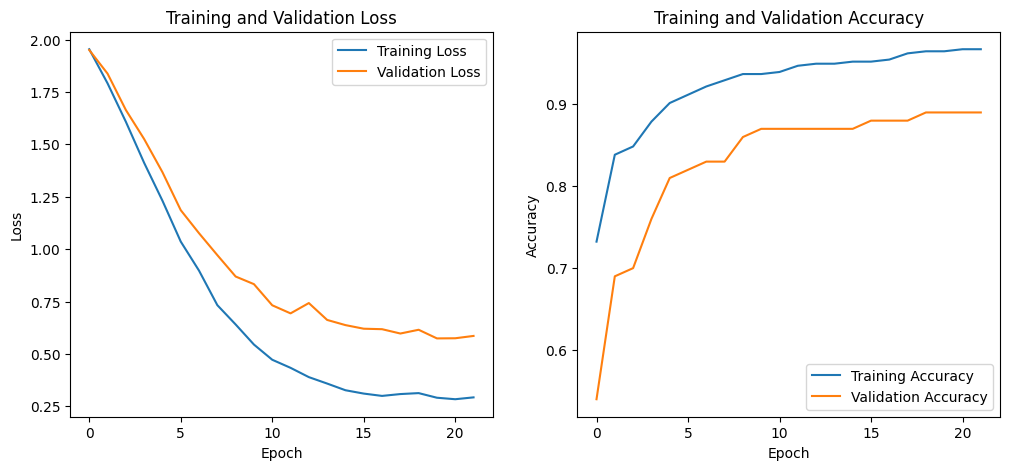

<All keys matched successfully>

In [44]:
model_random = GCN(num_node_features=data.x.shape[1], num_hidden=best_params['num_hidden'], num_classes=data.y.max().item() + 1).to(device)
optimizer = torch.optim.Adam(model_random.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
best_model_state, train_loss, val_loss, train_acc, val_acc = train_final_model(data0, model_random, optimizer)
plot_curves(train_loss, val_loss, train_acc, val_acc)

model_random.load_state_dict(best_model_state)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.94      1.00      0.97        16
           2       0.93      0.87      0.90        31
           3       0.94      0.94      0.94        16
           4       1.00      0.75      0.86         8
           5       0.75      1.00      0.86         6
           6       0.62      0.80      0.70        10

    accuracy                           0.89       100
   macro avg       0.88      0.89      0.88       100
weighted avg       0.91      0.89      0.89       100



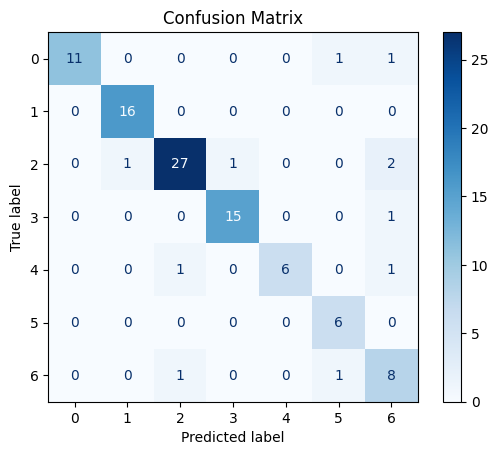

In [45]:
y_true, y_pred = evaluate_and_report(model_random, data0)
print("Classification Report:\n", classification_report(y_true, y_pred))

class_labels = np.unique(labels)
plot_confusion_matrix(y_true, y_pred, labels=class_labels)


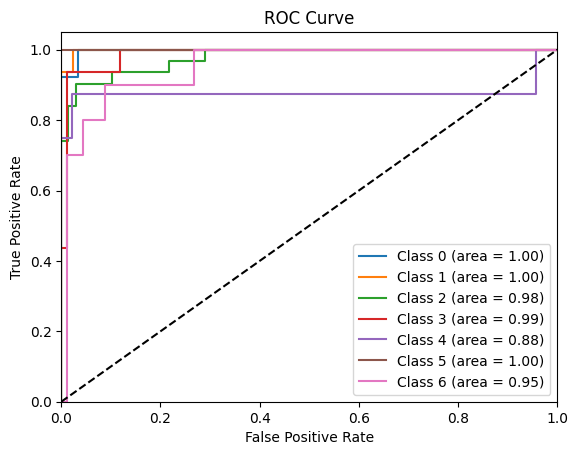

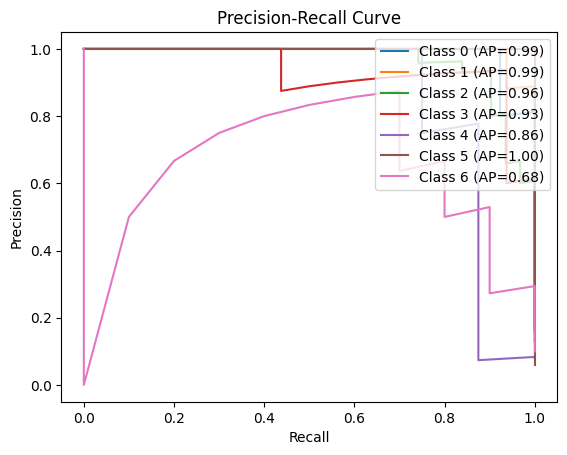

In [47]:
y_true, probabilities = evaluate_and_get_probabilities(model_random, data0)

n_classes = 7
plot_multiclass_roc_curve(y_true, probabilities, n_classes=n_classes)
plot_multiclass_precision_recall_curve(y_true, probabilities, n_classes=n_classes)

## Saving best model accuracy

In [48]:
model_random.eval()
pred = model_random(data0).argmax(dim=1)
preds = pred[idx_test]
np.savetxt('submission6_89_1.txt', preds, fmt='%d')

## Bayesian Optimization

In [50]:

space = [
    Real(1e-4, 1e-1, "log-uniform", name="lr"),
    Real(1e-4, 1e-2, "log-uniform", name="weight_decay"),
    Integer(8, 128, name="num_hidden")
]

@use_named_args(space)
def objective(**params):
    lr = params["lr"]
    weight_decay = params["weight_decay"]
    num_hidden = params["num_hidden"]

    avg_acc = 0
    for train_idx, val_idx in kf.split(idx_train0):
        idx_train, idx_val = idx_train0[train_idx], idx_train0[val_idx]
        train_mask = torch.zeros(x.size(0), dtype=torch.bool)
        train_mask[idx_train] = True
        val_mask = torch.zeros(x.size(0), dtype=torch.bool)
        val_mask[idx_val] = True

        data.train_mask = train_mask
        data.val_mask = val_mask

        model = GCN(num_node_features=data.x.shape[1], num_hidden=num_hidden, num_classes=data.y.max().item() + 1).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        acc, train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(data, model, optimizer)
        avg_acc += acc

    avg_acc /= n_splits
    print(f"lr: {lr}, weight_decay: {weight_decay}, num_hidden: {num_hidden}, Avg. Accuracy: {avg_acc:.4f}")

    return -avg_acc

num_bayesian_iter = 20
optimizer = Optimizer(space, base_estimator="GP", n_initial_points=5)
best_acc = -np.inf
best_params = None

for i in range(num_bayesian_iter):
    next_x = optimizer.ask()
    f_val = objective(next_x)
    optimizer.tell(next_x, f_val)

    if -f_val > best_acc:
        best_acc = -f_val
        best_params = {'lr': next_x[0], 'weight_decay': next_x[1], 'num_hidden': next_x[2]}

print(f"Best parameters: {best_params}, Best average accuracy: {best_acc:.4f}")



lr: 0.03928036718110113, weight_decay: 0.005337843152010053, num_hidden: 123, Avg. Accuracy: 0.8346
lr: 0.00012429312255805584, weight_decay: 0.005935574191548977, num_hidden: 112, Avg. Accuracy: 0.8105
lr: 0.001841271826000219, weight_decay: 0.00029508517504593017, num_hidden: 98, Avg. Accuracy: 0.8448
lr: 0.00021479081853465352, weight_decay: 0.0003314624372117089, num_hidden: 125, Avg. Accuracy: 0.8609
lr: 0.07040981041423783, weight_decay: 0.0024042663792403587, num_hidden: 19, Avg. Accuracy: 0.8245
lr: 0.0001, weight_decay: 0.00017690693012888364, num_hidden: 124, Avg. Accuracy: 0.8105
lr: 0.00025127375071163667, weight_decay: 0.0005843372890897062, num_hidden: 96, Avg. Accuracy: 0.8447
lr: 0.00019578372256402407, weight_decay: 0.00013402524792091702, num_hidden: 103, Avg. Accuracy: 0.8428
lr: 0.0002725661293195956, weight_decay: 0.00010337580782199259, num_hidden: 128, Avg. Accuracy: 0.8588
lr: 0.0004937404604668694, weight_decay: 0.004006730353202013, num_hidden: 128, Avg. Accur

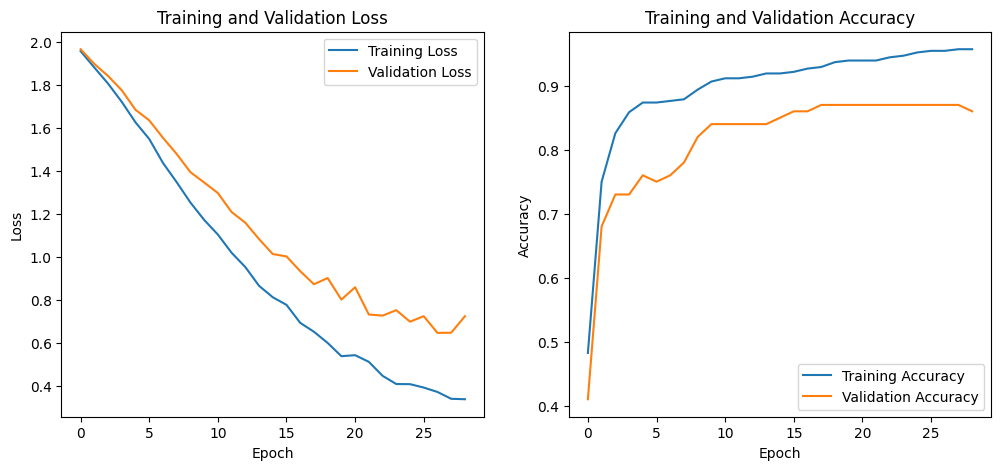

<All keys matched successfully>

In [72]:
model_bay = GCN(num_node_features=data.x.shape[1], num_hidden=best_params['num_hidden'], num_classes=data.y.max().item() + 1).to(device)
optimizer = torch.optim.Adam(model_bay.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
best_model_state, train_loss, val_loss, train_acc, val_acc = train_final_model(data0, model_bay, optimizer)
plot_curves(train_loss, val_loss, train_acc, val_acc)

model_bay.load_state_dict(best_model_state)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       1.00      1.00      1.00        16
           2       0.90      0.84      0.87        31
           3       0.88      0.88      0.88        16
           4       1.00      0.75      0.86         8
           5       0.75      1.00      0.86         6
           6       0.53      0.80      0.64        10

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.85       100
weighted avg       0.89      0.86      0.87       100



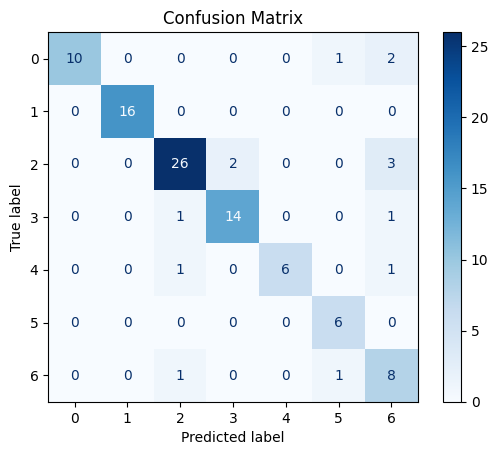

In [73]:
y_true, y_pred = evaluate_and_report(model_bay, data0)
print("Classification Report:\n", classification_report(y_true, y_pred))

class_labels = np.unique(labels)
plot_confusion_matrix(y_true, y_pred, labels=class_labels)


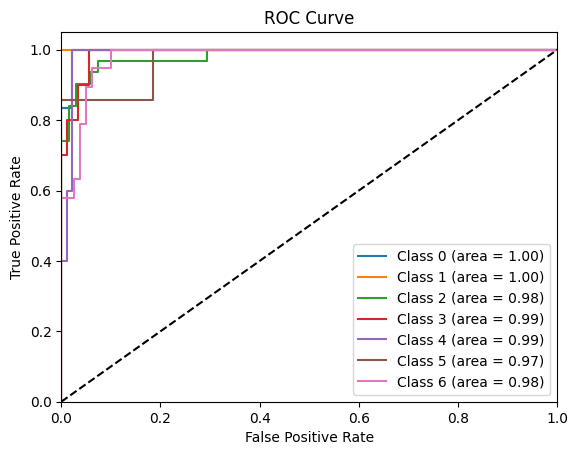

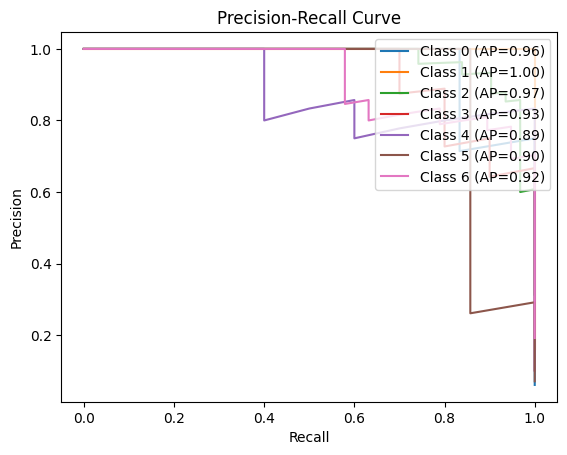

In [54]:
y_true, probabilities = evaluate_and_get_probabilities(model_bay, data)

n_classes = 7
plot_multiclass_roc_curve(y_true, probabilities, n_classes=n_classes)
plot_multiclass_precision_recall_curve(y_true, probabilities, n_classes=n_classes)

## Model Ensembling

In [55]:
from torch_geometric.nn import GCNConv, AGNNConv

class GCNAGNN(torch.nn.Module):
    def __init__(self, num_node_features, num_hidden, num_classes, activation='relu', dropout=0.5):
        super(GCNAGNN, self).__init__()
        self.activation = activation
        self.gcn = GCNConv(num_node_features, num_hidden)
        self.dropout = torch.nn.Dropout(dropout)
        self.agnn = AGNNConv(requires_grad=True)
        self.linear = torch.nn.Linear(num_hidden, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        if self.activation == 'relu':
            activation_function = F.relu
        elif self.activation == 'leaky_relu':
            activation_function = F.leaky_relu
        else:
            raise ValueError("Invalid activation function")

        x = activation_function(self.gcn(x, edge_index))
        x = self.dropout(x)
        x = self.agnn(x, edge_index)
        x = self.linear(x)
        return F.log_softmax(x, dim=1)


In [56]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
param_grid = {
    'lr': [0.005, 0.01],
    'weight_decay': [1e-4, 3e-3, 1e-5],
    'num_hidden': [32, 64],
    'optimizer': ['Adam', 'RMSprop'],
    'activation': ['leaky_relu', 'elu',],
    'dropout': [0.2, 0.5, 0.7]
}

best_params = None
best_acc = 0
idx_train0 = np.array(idx_train0)
for lr in param_grid['lr']:
    for weight_decay in param_grid['weight_decay']:
        for num_hidden in param_grid['num_hidden']:
            for optimizer_type in param_grid['optimizer']:
                for activation in param_grid['activation']:
                    for dropout in param_grid['dropout']:
                        avg_acc = 0
                        for train_idx, val_idx in kf.split(idx_train0):
                            idx_train, idx_val = idx_train0[train_idx], idx_train0[val_idx]
                            train_mask = torch.zeros(x.size(0), dtype=torch.bool)
                            train_mask[idx_train] = True
                            val_mask = torch.zeros(x.size(0), dtype=torch.bool)
                            val_mask[idx_val] = True

                            data.train_mask = train_mask
                            data.val_mask = val_mask
                            model = GCNAGNN(num_node_features=data.x.shape[1], num_hidden=num_hidden, num_classes=data.y.max().item() + 1, activation=activation, dropout=dropout).to(device)
                            if optimizer_type == 'Adam':
                                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
                            elif optimizer_type == 'RMSprop':
                                optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
                            elif optimizer_type == 'SGD':
                                optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)
                            acc, train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(data, model, optimizer)
                            avg_acc += acc

                        avg_acc /= n_splits
                        print(f"lr: {lr}, weight_decay: {weight_decay}, num_hidden: {num_hidden}, optimizer: {optimizer_type}, activation: {activation}, dropout: {dropout}, Avg. Accuracy: {avg_acc:.4f}")

                        if avg_acc > best_acc:
                            best_acc = avg_acc
                            best_params = {'lr': lr, 'weight_decay': weight_decay, 'num_hidden': num_hidden, 'optimizer': optimizer_type, 'activation': activation, 'dropout': dropout}

print(f"Best parameters: {best_params}, Best average accuracy: {best_acc:.4f}")


lr: 0.005, weight_decay: 0.0001, num_hidden: 32, optimizer: Adam, activation: leaky_relu, dropout: 0.2, Avg. Accuracy: 0.8387
lr: 0.005, weight_decay: 0.0001, num_hidden: 32, optimizer: Adam, activation: leaky_relu, dropout: 0.5, Avg. Accuracy: 0.8428
lr: 0.005, weight_decay: 0.0001, num_hidden: 32, optimizer: Adam, activation: leaky_relu, dropout: 0.7, Avg. Accuracy: 0.8528
lr: 0.005, weight_decay: 0.0001, num_hidden: 32, optimizer: Adam, activation: elu, dropout: 0.2, Avg. Accuracy: 0.8447
lr: 0.005, weight_decay: 0.0001, num_hidden: 32, optimizer: Adam, activation: elu, dropout: 0.5, Avg. Accuracy: 0.8528
lr: 0.005, weight_decay: 0.0001, num_hidden: 32, optimizer: Adam, activation: elu, dropout: 0.7, Avg. Accuracy: 0.8447
lr: 0.005, weight_decay: 0.0001, num_hidden: 32, optimizer: RMSprop, activation: leaky_relu, dropout: 0.2, Avg. Accuracy: 0.8387
lr: 0.005, weight_decay: 0.0001, num_hidden: 32, optimizer: RMSprop, activation: leaky_relu, dropout: 0.5, Avg. Accuracy: 0.8427
lr: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       1.00      1.00      1.00        16
           2       0.93      0.87      0.90        31
           3       0.94      0.94      0.94        16
           4       1.00      0.75      0.86         8
           5       0.75      1.00      0.86         6
           6       0.57      0.80      0.67        10

    accuracy                           0.89       100
   macro avg       0.88      0.89      0.88       100
weighted avg       0.91      0.89      0.89       100



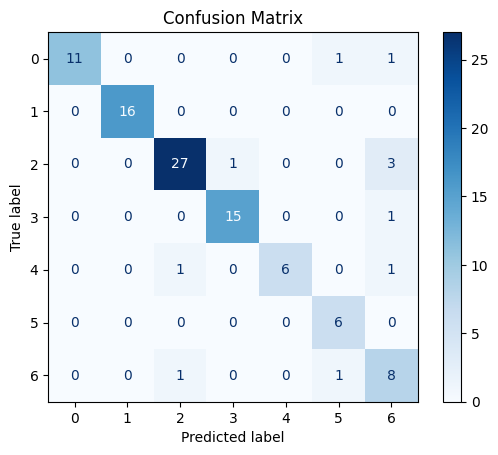

In [63]:

model_GCAN = GCNAGNN(num_node_features=data.x.shape[1], num_hidden=best_params['num_hidden'], num_classes=data.y.max().item() + 1, activation=best_params['activation'], dropout=best_params['dropout']).to(device)
optimizer = torch.optim.Adam(model_GCAN.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
best_model_state, train_loss, val_loss, train_acc, val_acc = train_final_model(data0, model_GCAN, optimizer)

model_GCAN.load_state_dict(best_model_state)
y_true, y_pred = evaluate_and_report(model_GCAN, data0)
print("Classification Report:\n", classification_report(y_true, y_pred))

class_labels = np.unique(labels)
plot_confusion_matrix(y_true, y_pred, labels=class_labels)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.94      1.00      0.97        16
           2       0.96      0.84      0.90        31
           3       0.82      0.90      0.86        10
           4       0.83      1.00      0.91        10
           5       0.78      1.00      0.88         7
           6       0.83      0.79      0.81        19

    accuracy                           0.89        99
   macro avg       0.88      0.91      0.89        99
weighted avg       0.90      0.89      0.89        99



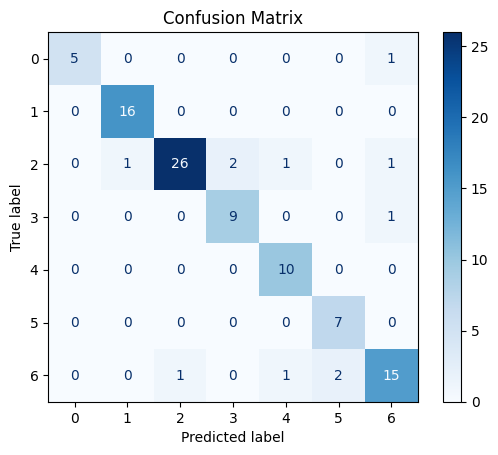

In [65]:
model_GCAN0 = GCNAGNN(num_node_features=data.x.shape[1], num_hidden=best_params['num_hidden'], num_classes=data.y.max().item() + 1, activation=best_params['activation'], dropout=best_params['dropout']).to(device)
optimizer = torch.optim.Adam(model_GCAN0.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
best_model_state0, train_loss, train_acc, train_acc, val_acc = train_final_model(data, model_GCAN0, optimizer)

model_GCAN0.load_state_dict(best_model_state0)

y_true, y_pred = evaluate_and_report(model_GCAN0, data)
print("Classification Report:\n", classification_report(y_true, y_pred))

class_labels = np.unique(labels)
plot_confusion_matrix(y_true, y_pred, labels=class_labels)

## Saving best performing model for final submission

In [66]:
model_GCAN.eval()
pred = model_GCAN(data0).argmax(dim=1)
preds = pred[idx_test]
np.savetxt('submission.txt', preds, fmt='%d')

In [67]:
preds

tensor([6, 2, 2,  ..., 1, 1, 5])